In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
sys.path.append(os.path.abspath("..")) 
from src.training.train import train_autoencoder, train_cellfate
from sklearn.model_selection import train_test_split
from src.models.classifier import mlp_classifier
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from src.preprocessing.preprocessing_functions import augment_dataset, augmentations

# Splitting data

In [10]:
x_train = np.load('../data/images/train_no_aug_time_norm.npy')[:,0,:,:]  
y_train = np.load('../data/labels/train_labels.npy')  
x_test = np.load('../data/images/test_time_norm.npy')[:,0,:,:]
y_test = np.load('../data/labels/test_labels.npy')

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

# Combine all your data
x_all = np.concatenate([x_train, x_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

print(f"Combined data shape: {x_all.shape}")
print(f"Combined labels shape: {y_all.shape}")

# First split: 60% train, 40% temp (which will become 20% val + 20% test)
x_train_new, x_temp, y_train_new, y_temp = train_test_split(
    x_all, y_all, 
    test_size=0.4,  # 40% for temp (val + test)
    random_state=42, 
    stratify=y_all  # Keep class balance
)

# Second split: Split the 40% temp into 20% val + 20% test
x_val, x_test_new, y_val, y_test_new = train_test_split(
    x_temp, y_temp,
    test_size=0.5,  # 50% of 40% = 20% of total
    random_state=42,
    stratify=y_temp  # Keep class balance
)

# Verify the splits
total_samples = len(x_all)
print(f"\nSplit verification:")
print(f"Train: {len(x_train_new)} samples ({len(x_train_new)/total_samples*100:.1f}%)")
print(f"Val:   {len(x_val)} samples ({len(x_val)/total_samples*100:.1f}%)")
print(f"Test:  {len(x_test_new)} samples ({len(x_test_new)/total_samples*100:.1f}%)")

# Check class balance in each split
print(f"\nClass distribution:")
print(f"Train - Class 0: {np.sum(y_train_new == 0)}, Class 1: {np.sum(y_train_new == 1)}")
print(f"Val   - Class 0: {np.sum(y_val == 0)}, Class 1: {np.sum(y_val == 1)}")
print(f"Test  - Class 0: {np.sum(y_test_new == 0)}, Class 1: {np.sum(y_test_new == 1)}")


Combined data shape: (1385, 20, 20)
Combined labels shape: (1385,)

Split verification:
Train: 831 samples (60.0%)
Val:   277 samples (20.0%)
Test:  277 samples (20.0%)

Class distribution:
Train - Class 0: 694, Class 1: 137
Val   - Class 0: 231, Class 1: 46
Test  - Class 0: 232, Class 1: 45


In [22]:
augmented_x_train, augmented_y_train = augment_dataset(
                x_train_new, 
                y_train_new, 
                augmentations, 
                augment_times=5,
                seed=42
            )

Balancing Class 0: 4164 → 822 samples (preserving augmentation structure)
✅ Balanced Class 0: 822 samples with equal augmentation representation


In [25]:
# np.save('../data/final_split/x_train.npy', x_train_new)
# np.save('../data/final_split/y_train.npy', y_train_new)
# np.save('../data/final_split/x_val.npy', x_val)
# np.save('../data/final_split/y_val.npy', y_val)
# np.save('../data/final_split/x_test.npy', x_test_new)
# np.save('../data/final_split/y_test.npy', y_test_new)
# np.save('../data/final_split/augmented_x_train.npy', augmented_x_train)
# np.save('../data/final_split/augmented_y_train.npy', augmented_y_train)

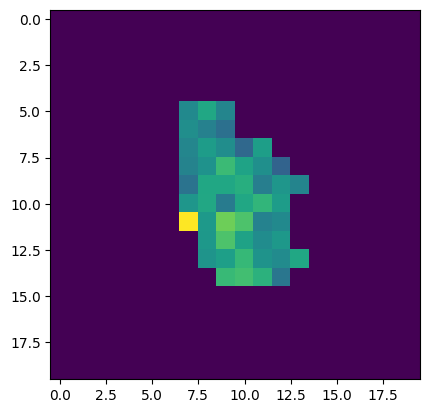

In [23]:
plt.imshow(augmented_x_train[1])

In [134]:
def augment_dataset_no_shuffle(cell_images, labels, augmentations, augment_times=5, fate_0_label=0, fate_1_label=1, seed=42):
    """
    Augments a dataset of cell movies (cells, time, height, width), balances fate 0 and fate 1,
    and ensures reproducibility by setting a seed.

    Args:
        cell_images (numpy.ndarray): Array of shape (cells, time, height, width).
        labels (numpy.ndarray): 1D array of labels corresponding to cell fates.
        augmentations (function): Function that applies augmentations to a movie sequence.
        augment_times (int): Number of unique augmented copies per movie.
        fate_0_label (int): Label for fate 0 cells.
        fate_1_label (int): Label for fate 1 cells.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: Augmented and balanced (final_images, final_labels).
    """
    np.random.seed(seed)  # Ensure reproducibility

    # Separate fate 0 and fate 1 in the dataset
    fate_0_images = cell_images[labels == fate_0_label]
    fate_1_images = cell_images[labels == fate_1_label]

    # Generate multiple unique augmentations per movie
    augmented_fate_0 = np.concatenate([augmentations(movie, augment_times) for movie in fate_0_images], axis=0)
    augmented_fate_1 = np.concatenate([augmentations(movie, augment_times) for movie in fate_1_images], axis=0)

    # Combine original and augmented data
    fate_0_combined = np.concatenate([fate_0_images, augmented_fate_0], axis=0)
    fate_1_combined = np.concatenate([fate_1_images, augmented_fate_1], axis=0)

    # Balance fate 0 to match fate 1 count
    target_count = len(fate_1_combined)
    #balanced_fate_0 = fate_0_combined[np.random.choice(len(fate_0_combined), size=target_count, replace=False)]
    # Instead of random choice, take the first target_count samples to preserve order
    balanced_fate_0 = fate_0_combined[:target_count]
    # Merge datasets
    final_images = np.concatenate([balanced_fate_0, fate_1_combined], axis=0)
    final_labels = np.array([fate_0_label] * len(balanced_fate_0) + [fate_1_label] * len(fate_1_combined))

    # Shuffle data
    #shuffle_indexes = np.random.permutation(len(final_labels))
    #final_images, final_labels = final_images[shuffle_indexes], final_labels[shuffle_indexes]

    return final_images, final_labels


def augmentations(movie, augment_times=4, seed=42):
    """
    Applies multiple **unique** augmentations to the whole movie (time-series of images).

    Args:
        movie (numpy.ndarray): Array of shape (time, height, width).
        augment_times (int): Number of unique augmented copies to generate.

    Returns:
        numpy.ndarray: Augmented movies (augment_times, time, height, width).
    """
    all_augmentations = [
        lambda x: np.flip(x, axis=-1),  # Flip horizontally
        lambda x: np.flip(x, axis=-2),  # Flip vertically
        lambda x: np.rot90(x, k=1, axes=(-2, -1)),  # Rotate 90 degrees
        lambda x: np.rot90(x, k=2, axes=(-2, -1)),  # Rotate 180 degrees
        lambda x: np.rot90(x, k=3, axes=(-2, -1))  # Rotate 270 degrees
    ]
    
    np.random.seed(seed)

    # Select random augmentations
    #np.random.shuffle(all_augmentations)

    selected_augmentations = all_augmentations[:augment_times]

    # Apply selected augmentations
    augmented_movies = [augment(movie) for augment in selected_augmentations]

    return np.array(augmented_movies)  # Shape: (augment_times, time, height, width)


In [ ]:
len(augmented_y_train[augmented_y_train==0])

822

In [135]:
augmented_x_train, augmented_y_train = augment_dataset_no_shuffle(
                x_train_new, 
                y_train_new, 
                augmentations, 
                augment_times=5,
                seed=42
            )

In [136]:
augmented_x_train.shape

(1644, 20, 20)

Analyzing structure...
Original Class 0 cells: 694


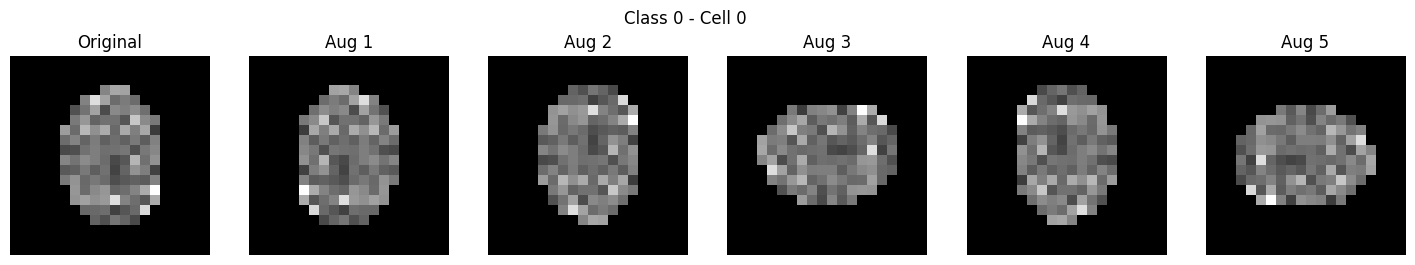

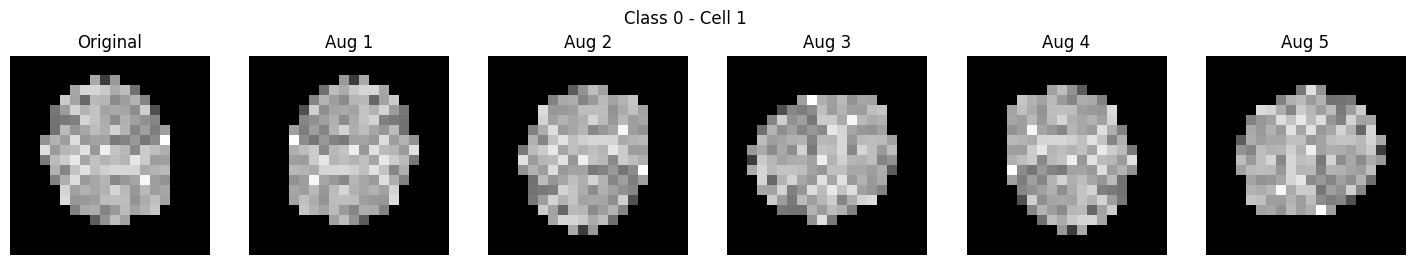

In [137]:
def show_cell_and_augmentations(cell_number, augmented_x_train, augmented_y_train, augment_times=5):
    """Show a specific cell and its augmentations from your current structure"""
    
    # Find where augmentations start (after all originals)
    # Count originals in each class
    class_0_count = np.sum(augmented_y_train == 0)
    class_1_start = class_0_count
    
    # For Class 0 cells
    if cell_number < len(x_train_new[y_train_new == 0]):  # Assuming this is available
        original_idx = cell_number
        aug_start_idx = len(x_train_new[y_train_new == 0]) + (cell_number * augment_times)
        
        fig, axes = plt.subplots(1, 6, figsize=(18, 3))
        
        # Show original
        axes[0].imshow(augmented_x_train[original_idx], cmap='gray')
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        # Show augmentations
        for i in range(augment_times):
            aug_idx = aug_start_idx + i
            axes[i+1].imshow(augmented_x_train[aug_idx], cmap='gray')
            axes[i+1].set_title(f"Aug {i+1}")
            axes[i+1].axis('off')
        
        plt.suptitle(f"Class 0 - Cell {cell_number}")
        plt.show()
    else:
        print("Cell number too high for available Class 0 cells")

# Let's figure out the exact structure first:
print("Analyzing structure...")
original_class0_count = len(x_train_new[y_train_new == 0])
print(f"Original Class 0 cells: {original_class0_count}")

# Test this with the first few cells
show_cell_and_augmentations(0, augmented_x_train, augmented_y_train)
show_cell_and_augmentations(1, augmented_x_train, augmented_y_train)

In [129]:
augmented_x_train.shape

(1644, 20, 20)

In [116]:
# After running your augmentation code, add this to see the structure:
augmented_x_train, augmented_y_train = augment_dataset_no_shuffle(
    x_train_new, 
    y_train_new, 
    augmentations, 
    augment_times=5,
    seed=42
)

# Check the structure
print(f"Total augmented samples: {len(augmented_x_train)}")
print(f"Original training samples: {len(x_train_new)}")
print(f"Augmentation factor: {len(augmented_x_train) / len(x_train_new):.1f}")

# Check first 20 labels to see the pattern
print(f"First 20 labels: {augmented_y_train[:20]}")
print(f"Labels 20-40: {augmented_y_train[20:40]}")

# Check class distribution in chunks
chunk_size = 50
for i in range(0, min(200, len(augmented_y_train)), chunk_size):
    chunk = augmented_y_train[i:i+chunk_size]
    print(f"Chunk {i}-{i+chunk_size}: Class 0: {np.sum(chunk==0)}, Class 1: {np.sum(chunk==1)}")

Total augmented samples: 1644
Original training samples: 831
Augmentation factor: 2.0
First 20 labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Labels 20-40: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Chunk 0-50: Class 0: 50, Class 1: 0
Chunk 50-100: Class 0: 50, Class 1: 0
Chunk 100-150: Class 0: 50, Class 1: 0
Chunk 150-200: Class 0: 50, Class 1: 0


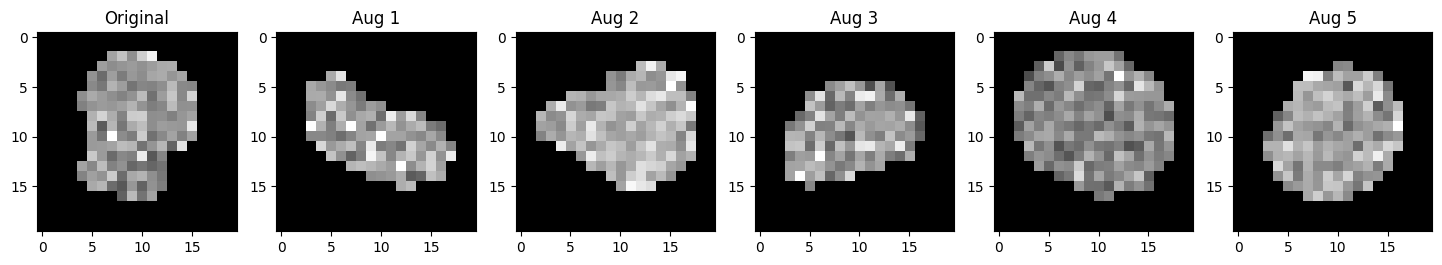

In [118]:
# Every 6 images = 1 original + 5 augmentations
original_idx = 0  # First cell
aug_indices = [1, 2, 3, 4, 5]  # Its augmentations

# Visualize
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
for i in range(6):
    axes[i].imshow(augmented_x_train[i], cmap='gray')
    if i == 0:
        axes[i].set_title("Original")
    else:
        axes[i].set_title(f"Aug {i}")
plt.show()

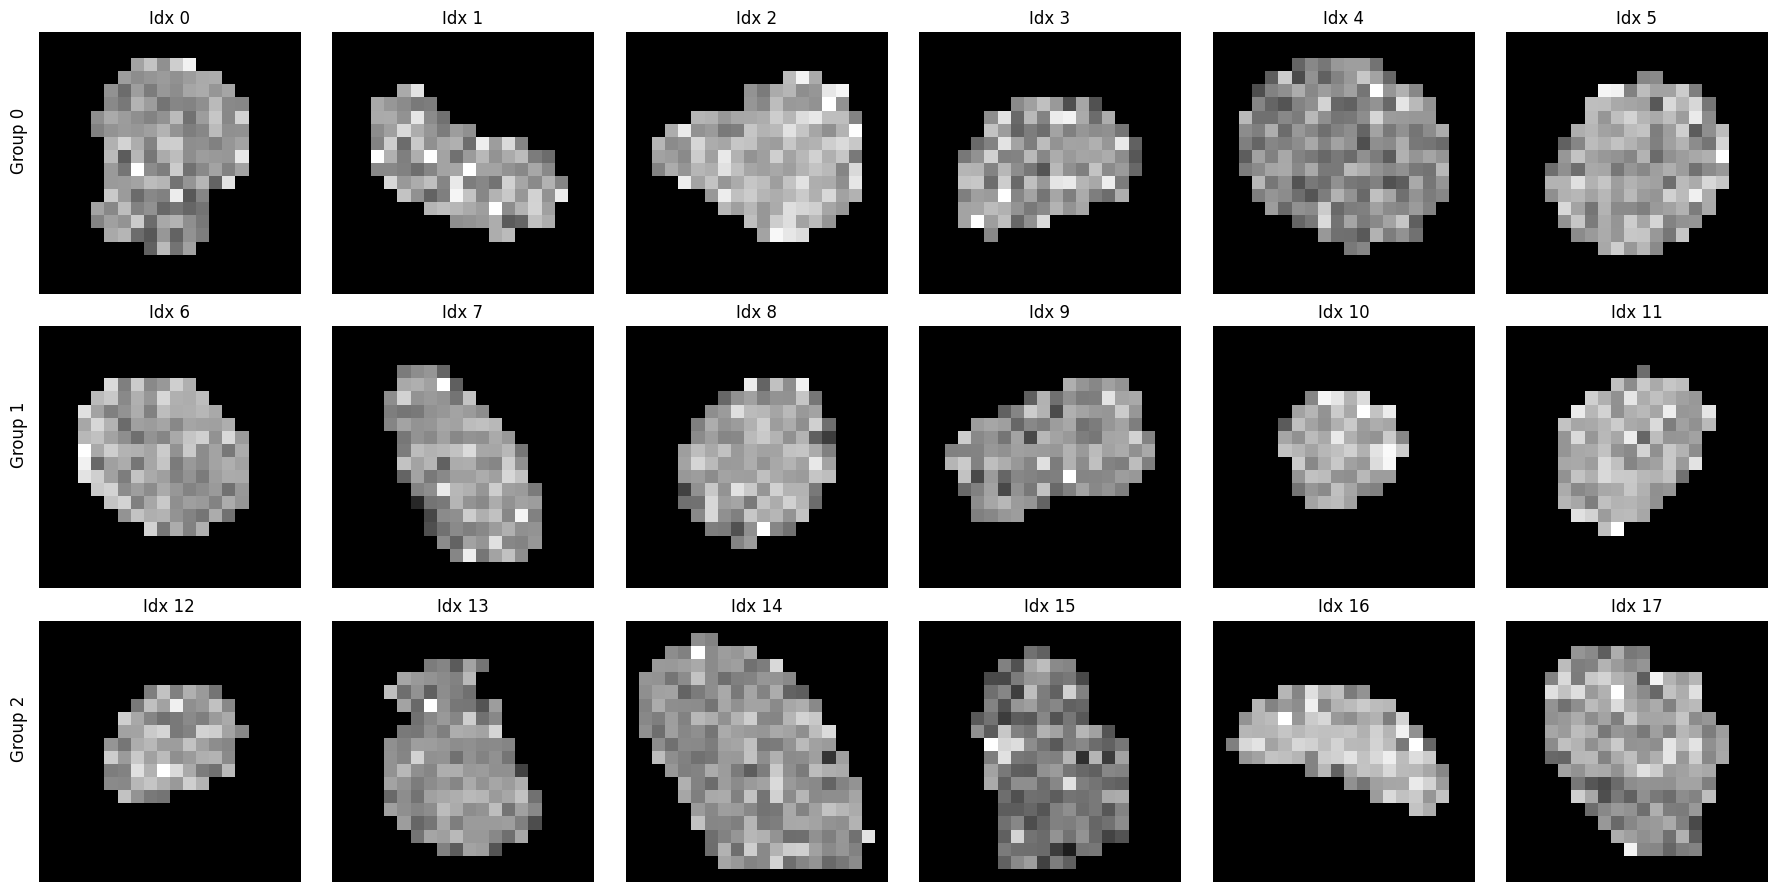

Let's check if the original order is preserved...
Sample at index 0 shape: (20, 20)
Sample at index 1 shape: (20, 20)


In [123]:
# Let's see what's really happening - check if consecutive samples are related
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

# Test 3 groups of 6 consecutive samples
for group in range(3):
    for i in range(6):
        idx = group * 6 + i  # indices 0-5, 6-11, 12-17
        axes[group, i].imshow(augmented_x_train[idx], cmap='gray')
        axes[group, i].set_title(f"Idx {idx}")
        axes[group, i].axis('off')
    
    # Add group label
    axes[group, 0].text(-2, 10, f'Group {group}', rotation=90, fontsize=12, ha='center')

plt.tight_layout()
plt.show()

# Also check if the function is actually preserving the order by looking at a known cell
print("Let's check if the original order is preserved...")
print(f"Sample at index 0 shape: {augmented_x_train[0].shape}")
print(f"Sample at index 1 shape: {augmented_x_train[1].shape}")

# Check if these look like the same cell with different transformations
# or completely different cells

In [ ]:
len(augmented_y_train[augmented_y_train==0])

822

In [ ]:
len(augmented_y_train[augmented_y_train==0])

822

In [ ]:
len(augmented_y_train[augmented_y_train==0])

822

In [ ]:
len(augmented_y_train[augmented_y_train==0])

822

In [112]:
len(augmented_y_train[augmented_y_train==0])

822

In [ ]:
len(augmented_y_train[augmented_y_train==0])

822

In [ ]:
len(augmented_y_train[augmented_y_train==0])

822

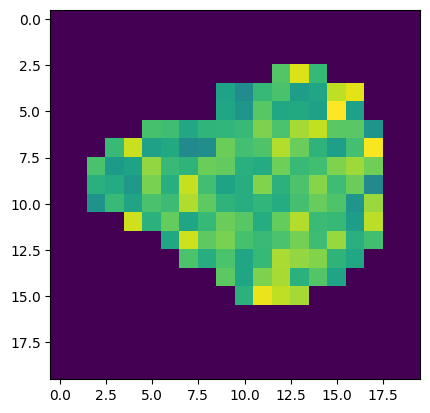

In [115]:
plt.imshow(augmented_x_train[2,:,:])

# Load Data

In [2]:
# Loading the first time point of the time-lapse microscopy data
x_train = np.load('../data/images/train_images_augmented.npy')[:,0,:,:] ###TODO: change to the data path
y_train = np.load('../data/labels/train_labels_augmented.npy') ###TODO: change to the data path
x_test = np.load('../data/images/test_images.npy')[:,0,:,:] ###TODO: change to the data path
y_test = np.load('../data/labels/test_labels.npy') ###TODO: change to the data path

# x_train = np.load('../data/images/train_no_aug_time_norm.npy')[:,0,:,:]  
# y_train = np.load('../data/labels/train_labels.npy')  
# x_test = np.load('../data/images/test_time_norm.npy')[:,0,:,:]
# y_test = np.load('../data/labels/test_labels.npy')

# Print the shape of the data
print("x_train.shape: ", x_train.shape, "y_train.shape: ", y_train.shape, "x_test.shape: ", x_test.shape, "y_test.shape: ", y_test.shape)

x_train.shape:  (2184, 20, 20) y_train.shape:  (2184,) x_test.shape:  (277, 20, 20) y_test.shape:  (277,)


# Load Pretrained AI4CellFate Model

In [3]:
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/models/autoencoder_cov/encoder.weights.h5") ###TODO: change to the model path
decoder.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/models/autoencoder_cov/decoder.weights.h5") ###TODO: change to the model path

/Users/inescunha/anaconda3/envs/testcellfate/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/testcellfate/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [4]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 20, 20, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_normaliza… │ (None, 20, 20, 2) │         22 │ encoder_input[0]… │
│ (SpectralNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 20, 20, 2) │          8 │ spectral_normali… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 20, 20, 2) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_normaliza… │ (None, 10, 10, 8) │        160 │ activation[0][0]  │
│ (SpectralNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 10, 10, 8) │          0 │ spectral_normali… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10, 8) │         32 │ gaussian_noise[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 10, 10, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_normaliza… │ (None, 10, 10, 8) │        592 │ activation_1[0][… │
│ (SpectralNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 10, 10, 8) │          0 │ spectral_normali… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_normaliza… │ (None, 10, 10, 8) │         32 │ spectral_normali… │
│ (SpectralNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 10, 8) │          0 │ gaussian_noise_1… │
│                     │                   │            │ spectral_normali… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10, 10, 8) │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10, 8) │         32 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 10, 10, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_normaliza… │ (None, 5, 5, 16)  │      1,184 │ activation_2[0][… │
│ (SpectralNormaliza… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_2    │ (None, 5, 5, 16)  │          0 │ spectral_normali… │
│ (GaussianNoise)     │                   │            │                 

 Total params: 5,434 (21.23 KB)

 Trainable params: 5,286 (20.65 KB)

 Non-trainable params: 148 (592.00 B)

## OPTIONAL: Train AI4CellFate from scratch

Stage 1: Train Adversarial Autoencoder for a low number of epochs, to wait for the reconstruction losses to converge before we do any latent space engineering

In [4]:
config_autoencoder = {
        'batch_size': 30,
        'epochs': 15,
        'learning_rate': 0.001,
        'seed': 42,
        'latent_dim': 2,
        'GaussianNoise_std': 0.003,
        'lambda_recon': 5,
        'lambda_adv': 1,
    }

lambda_autoencoder_results = train_autoencoder(config_autoencoder, x_train)
encoder = lambda_autoencoder_results['encoder']
decoder = lambda_autoencoder_results['decoder']
discriminator = lambda_autoencoder_results['discriminator']

Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 42, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2867, Adversarial loss: 0.7489, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.7749, Adversarial loss: 0.7269, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7638, Adversarial loss: 0.7135, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7467, Adversarial loss: 0.7116, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7450, Adversarial loss: 0.7094, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7531, Adversarial loss: 0.6986, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7237, Adversarial loss: 0.7067, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7281, Adversarial loss: 0.7037, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7274, Adversarial loss: 0.6983, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Stage 2: Train full AI4CellFate model (using the trained AAE from stage 1), where we add contrastive and covariance losses to enforce the latent features to be optimised for the classification task and independent from each other (for interpretation)

In [ ]:
config_ai4cellfate = {
        'batch_size': 30,
        'epochs': 100,
        'learning_rate': 0.001,
        'seed': 42,
        'latent_dim': 2,
        'GaussianNoise_std': 0.003,
        'lambda_recon': 6,
        'lambda_adv': 4,
        'lambda_cov': 0.0001,
        'lambda_contra': 8,
    }
 
lambda_ae_cov_results = train_cellfate(config_ai4cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test) 
encoder = lambda_ae_cov_results['encoder']
decoder = lambda_ae_cov_results['decoder']
discriminator = lambda_ae_cov_results['discriminator']

# Visualise Latent Space

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


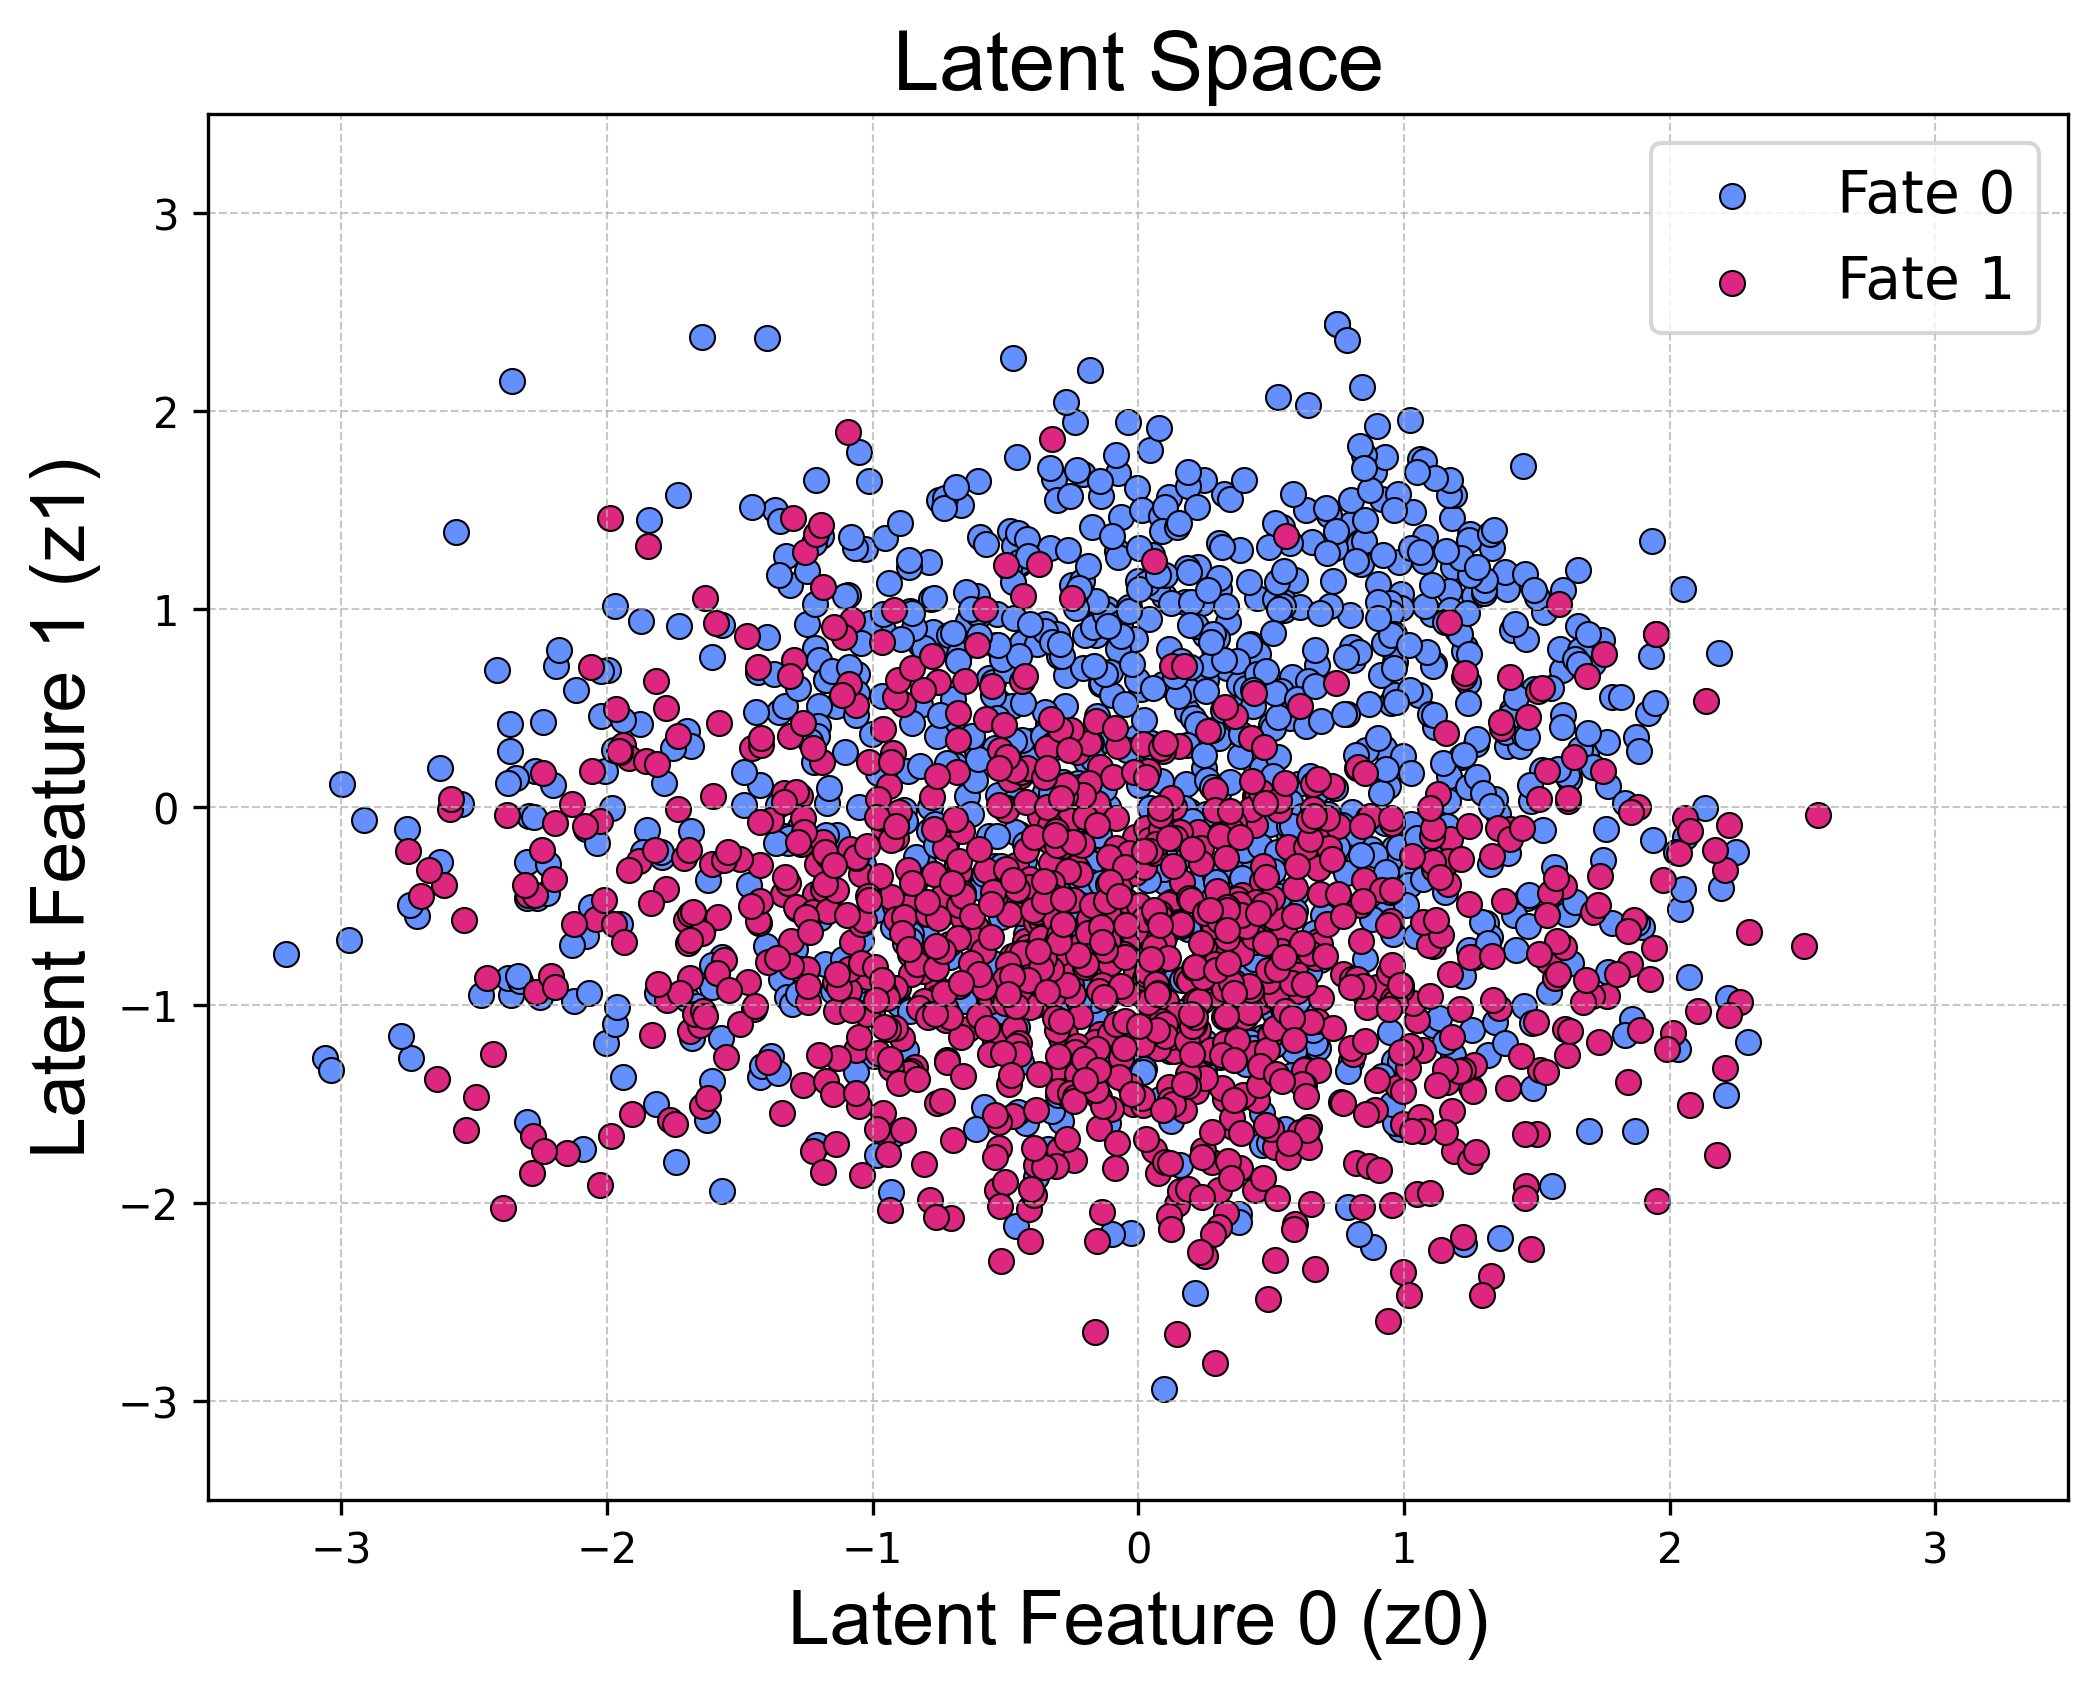

In [5]:
# Predict the latent representations
latent_2d = encoder.predict(x_train) 

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("rasterised_ls_cellfate.eps", dpi=600, bbox_inches="tight")
plt.show()

## Visualise Test Latent Space

1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


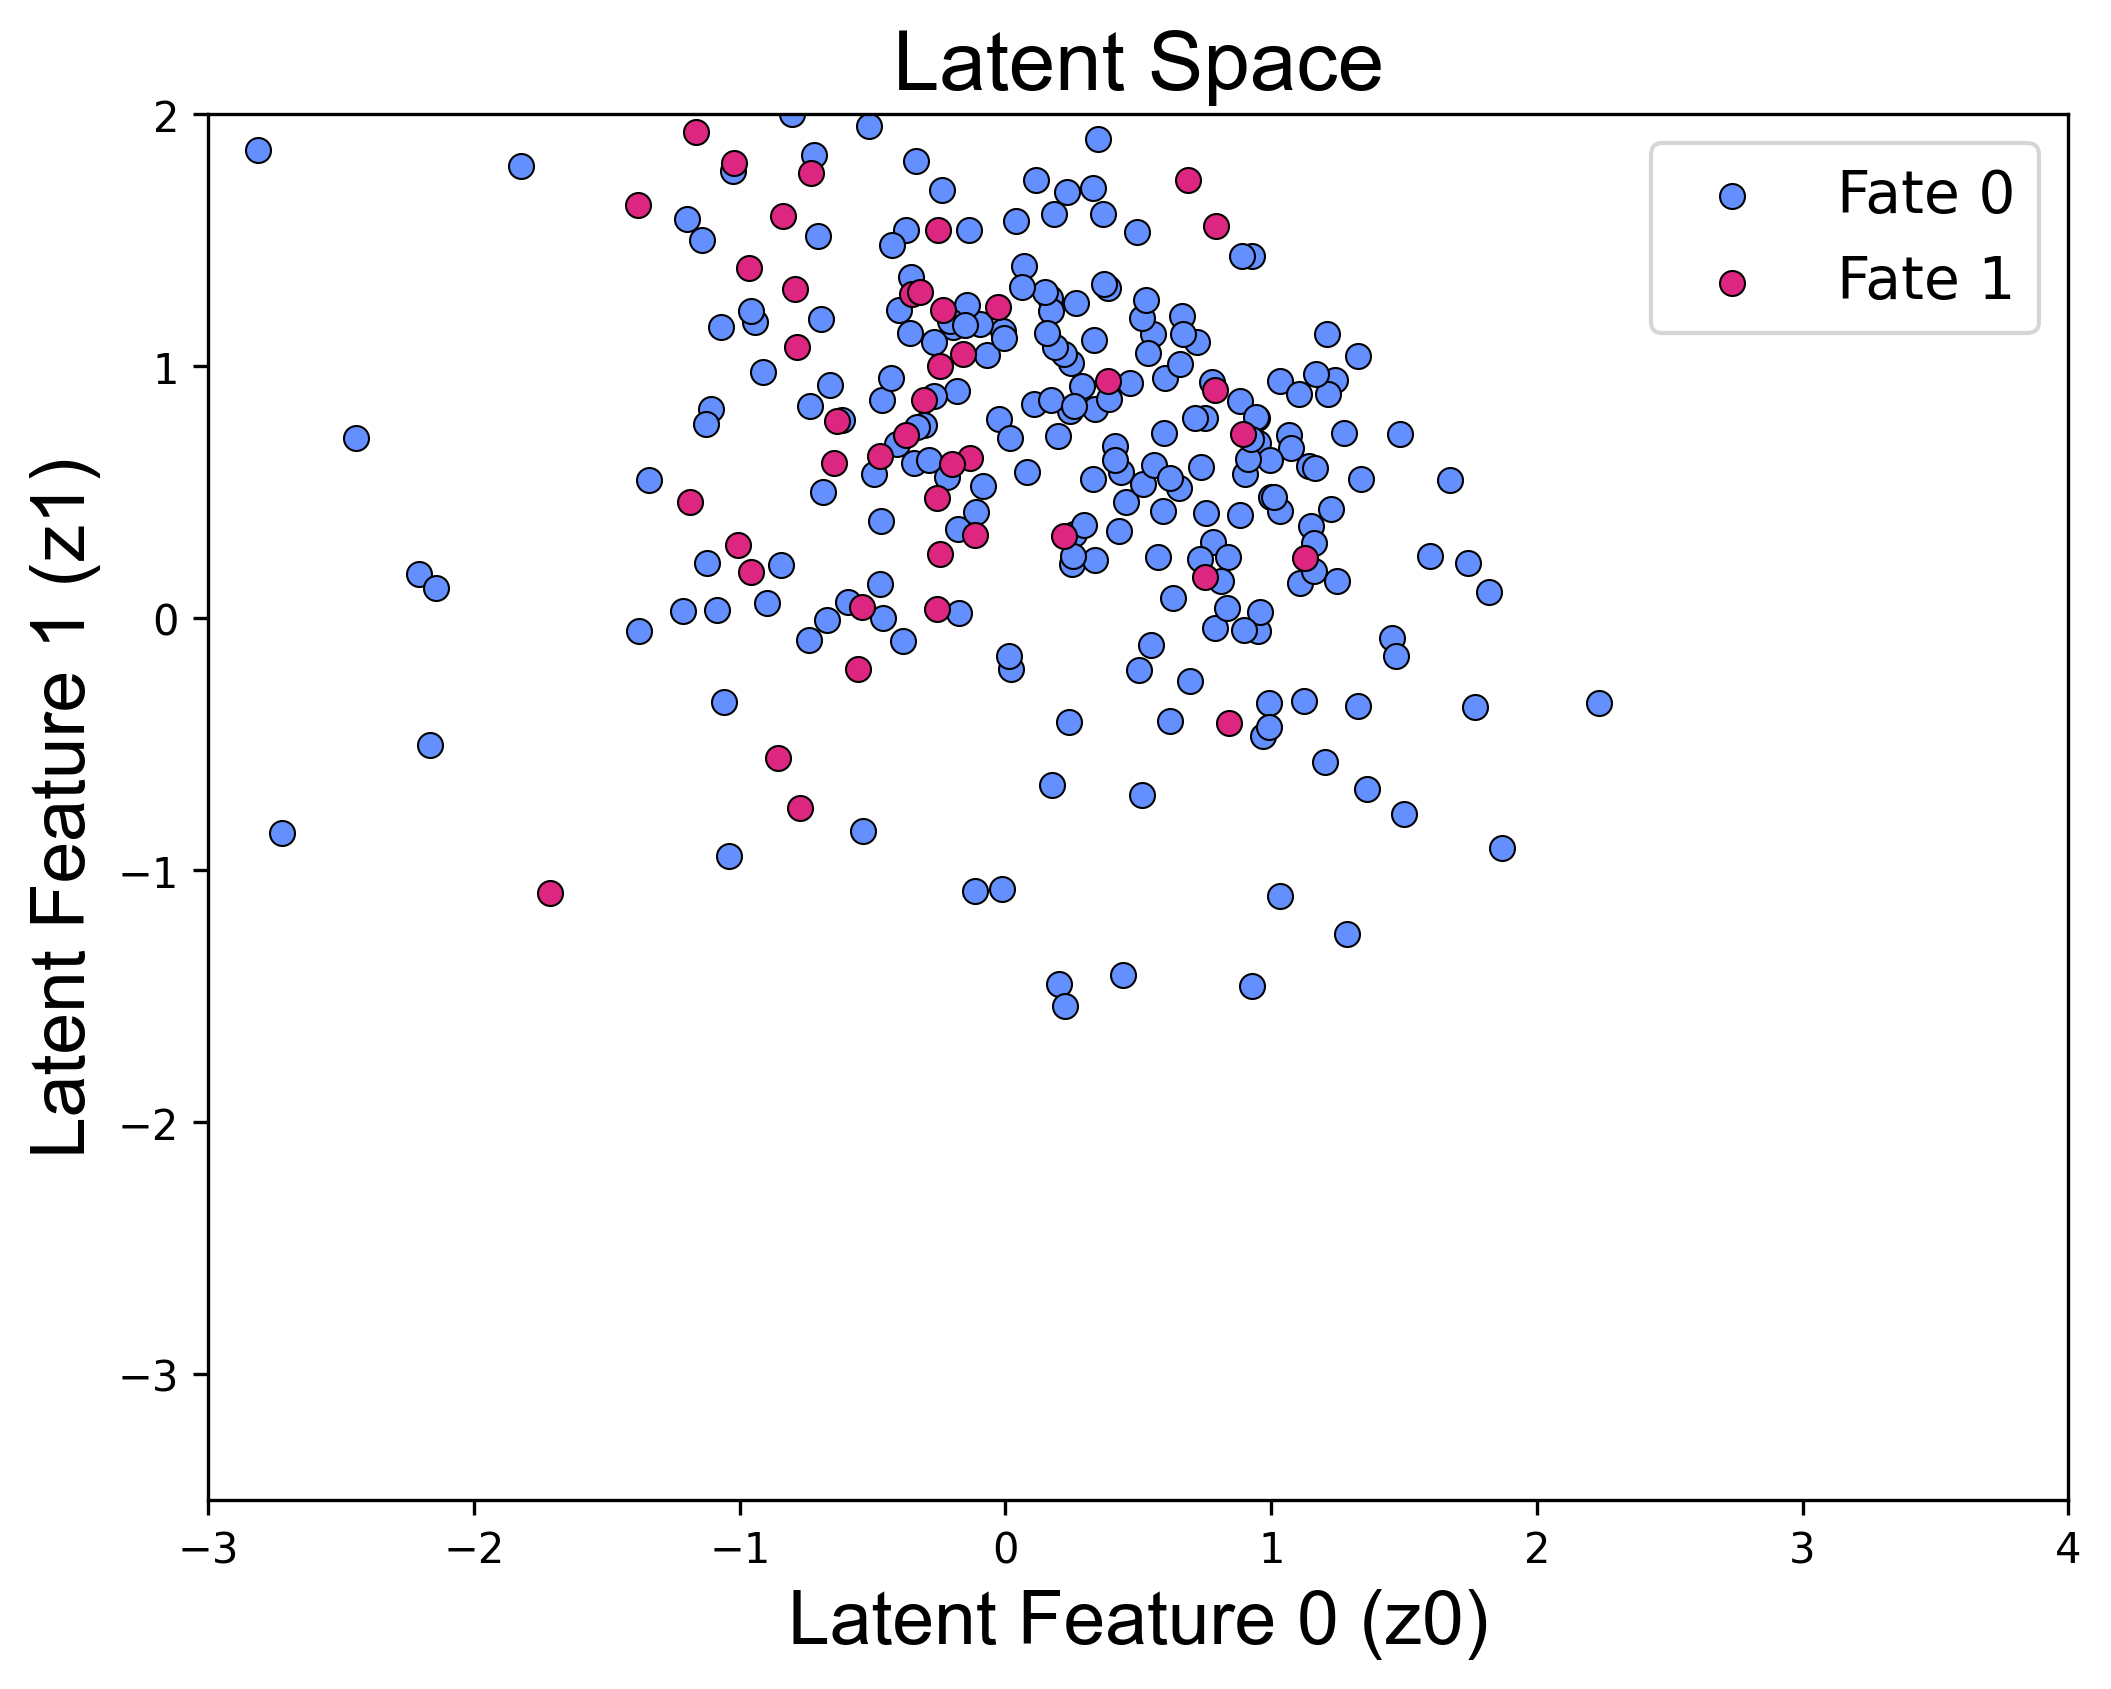

In [9]:
# Predict the latent representations
latent_2d = encoder.predict(x_test)  # Shape (1380, 2)

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[y_test == 0][:, 0], latent_2d[y_test == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[y_test == 1][:, 0], latent_2d[y_test == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
plt.xlim(-3, 4)
plt.ylim(-3.5, 2)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
#plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("test_cellfate_noaug_rasterised.eps", dpi=600, bbox_inches="tight")
plt.show()


In [10]:
from scipy.spatial.distance import euclidean
# Compute centroids
centroid_class_0 = np.mean(encoder.predict(x_test)[y_test == 0], axis=0)
centroid_class_1 = np.mean(encoder.predict(x_test)[y_test == 1], axis=0)

# Compute Euclidean distance between centroids
distance = euclidean(centroid_class_0, centroid_class_1)
print(f"Distance between class centroids: {distance:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Distance between class centroids: 0.5725


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


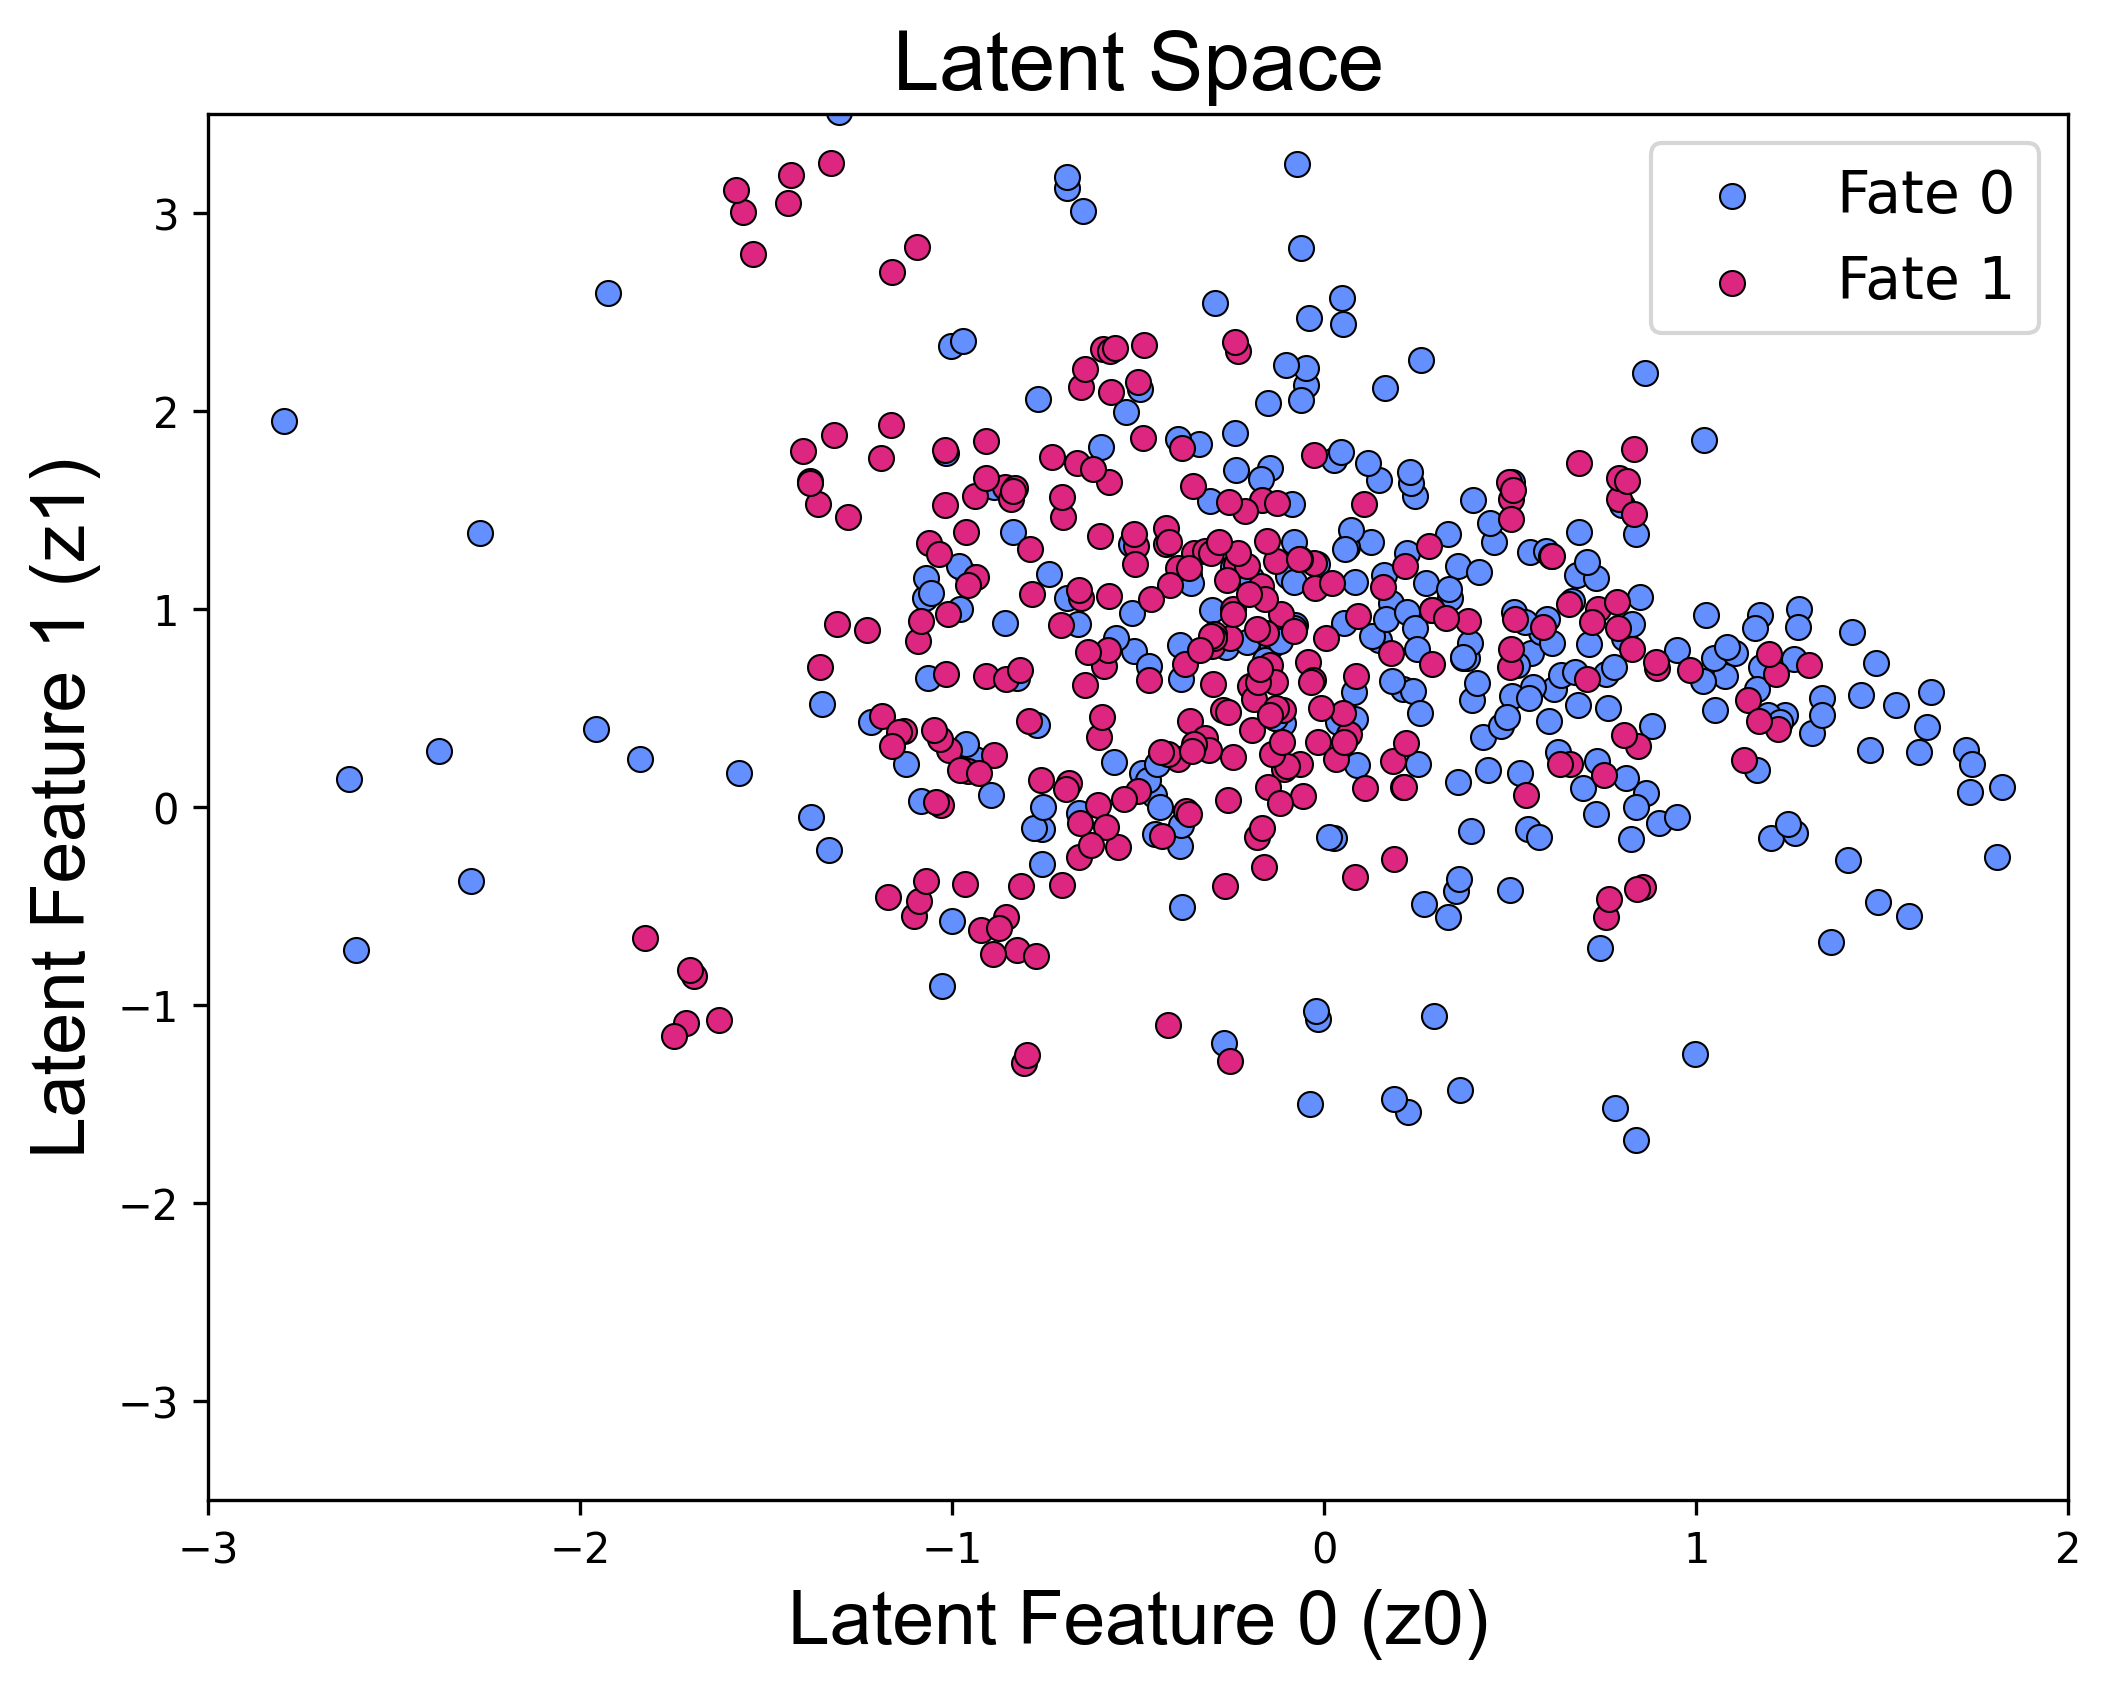

In [11]:
#### latent space correctly saved
from src.preprocessing.preprocessing_functions import *

augmented_x_test_for_visuals, augmented_y_test_for_visuals = augment_dataset(x_test, y_test, augmentations)

# Predict the latent representations
latent_2d = encoder.predict(augmented_x_test_for_visuals)  # Shape (1380, 2)

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[augmented_y_test_for_visuals == 0][:, 0], latent_2d[augmented_y_test_for_visuals == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[augmented_y_test_for_visuals == 1][:, 0], latent_2d[augmented_y_test_for_visuals == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
plt.xlim(-3, 2)
plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
#plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("test_cellfate_aug_rasterised.eps", dpi=600, bbox_inches="tight")
plt.show()


In [12]:
from scipy.spatial.distance import euclidean
# Compute centroids
centroid_class_0 = np.mean(encoder.predict(augmented_x_test_for_visuals)[augmented_y_test_for_visuals == 0], axis=0)
centroid_class_1 = np.mean(encoder.predict(augmented_x_test_for_visuals)[augmented_y_test_for_visuals == 1], axis=0)

# Compute Euclidean distance between centroids
distance = euclidean(centroid_class_0, centroid_class_1)
print(f"Distance between class centroids: {distance:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
Distance between class centroids: 0.4917


# Classify from Engineered Latent Space

In [13]:
config_clf = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

tf.keras.utils.set_random_seed(config_clf['seed'])

classifier = mlp_classifier(latent_dim=config_clf['latent_dim']) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6399 - loss: 0.6614 - val_accuracy: 0.7174 - val_loss: 0.6091
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6396 - loss: 0.6422 - val_accuracy: 0.7391 - val_loss: 0.5774
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6748 - loss: 0.6302 - val_accuracy: 0.7826 - val_loss: 0.5586
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.6562 - loss: 0.6348 - val_accuracy: 0.7536 - val_loss: 0.5433
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.6539 - loss: 0.6189 - val_accuracy: 0.7681 - val_loss: 0.5352
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.6699 - loss: 0.6302 - val_accuracy: 0.7681 - val_loss: 0.5298
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.6622 - loss: 0.6142 - val_accuracy: 0.7754 - val_loss: 0.5279
Epoch 8/50
73/73 ━━━━━━━━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[0.83783784 0.16216216]
 [0.71428571 0.28571429]]


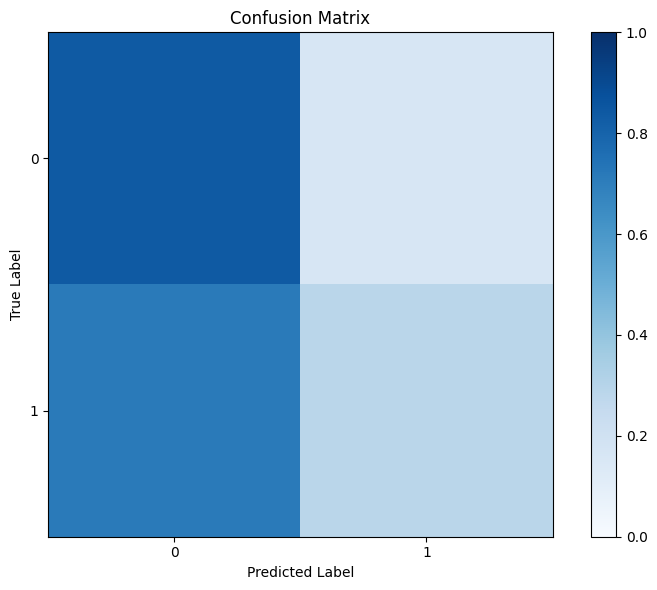

In [14]:
num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Visual Interpretation 

(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


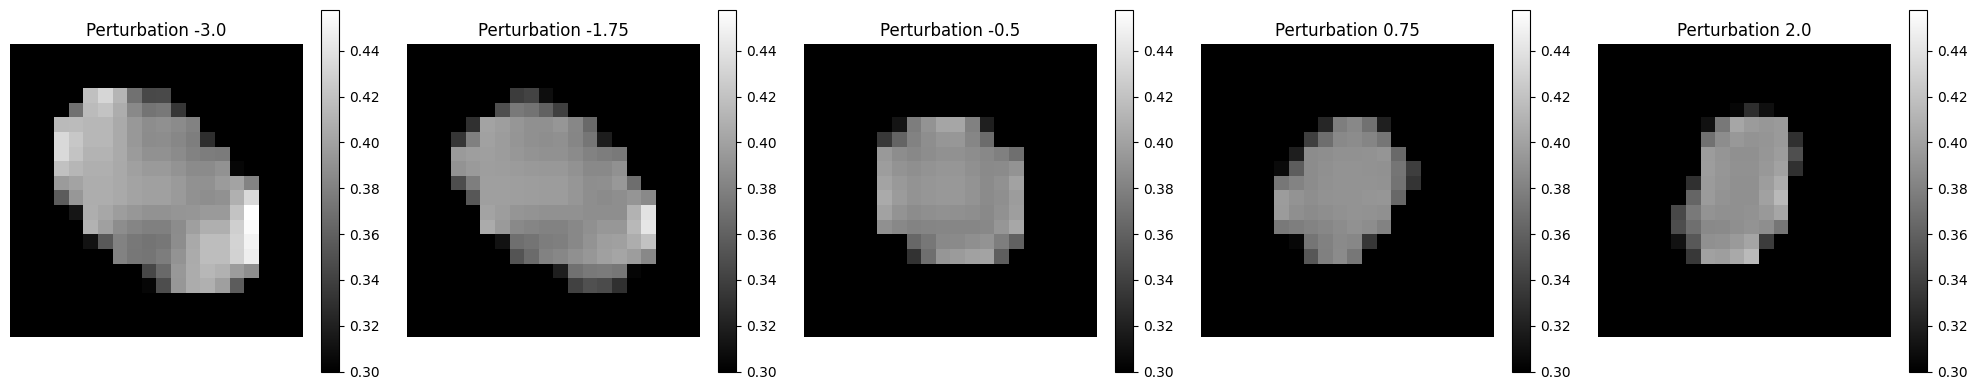

In [6]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 0

# Perturbation range
perturbations = np.linspace(-3, 2, 5) # feature index 1
#perturbations = np.linspace(-2.5, 1.5, 5) # feature index 0

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.3, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
#plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


### Feature Extraction on the Perturbed Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


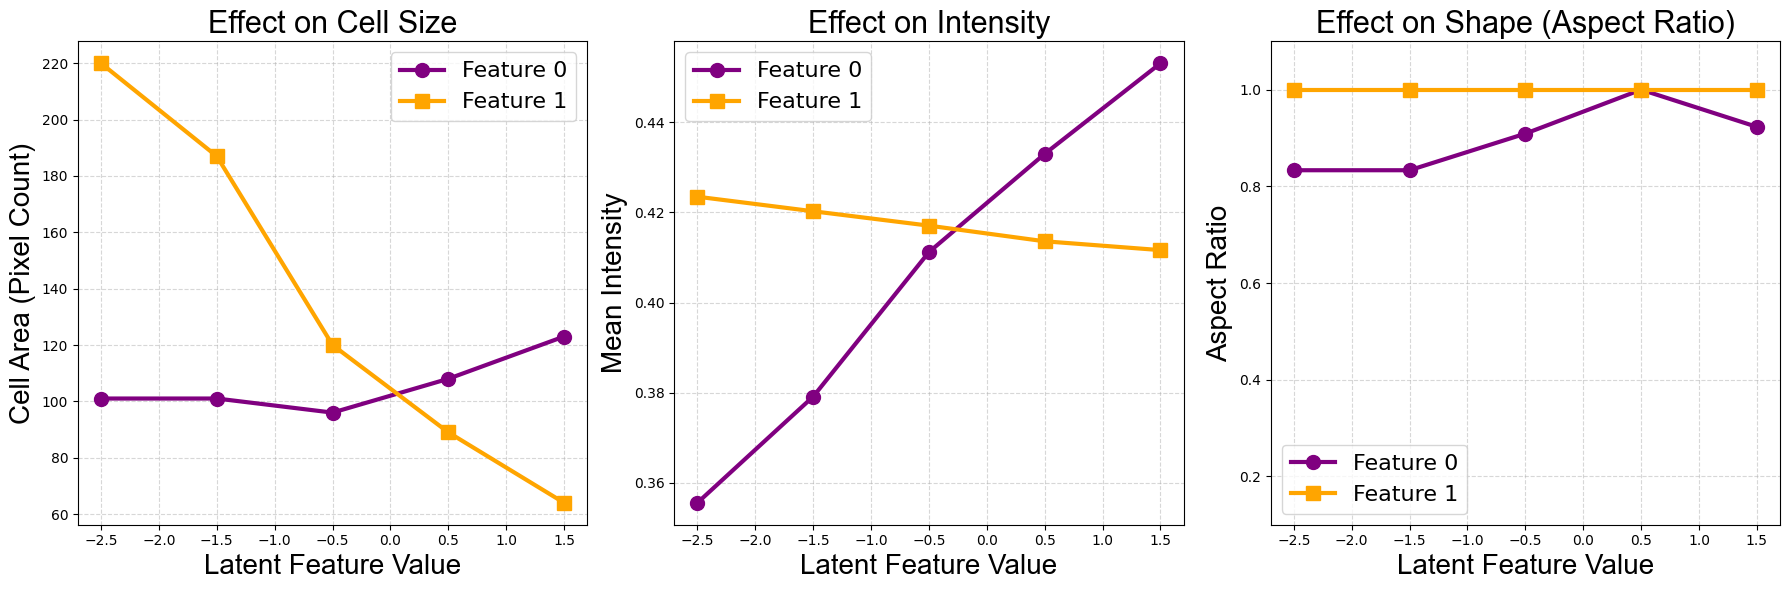

In [14]:
import cv2

# Initialize arrays to store feature effects
areas_0, areas_1 = [], []
intensities_0, intensities_1 = [], []
aspect_ratios_0, aspect_ratios_1 = [], []
circularities_0, circularities_1 = [], []

# Function to compute cell area
def compute_area(image, threshold=0.1):
    return np.sum(image > threshold)

# Function to compute mean intensity
def compute_intensity(image):
    return np.max(image)

# Function to compute shape descriptors (aspect ratio, circularity)
def compute_shape_features(image, threshold=0.1):
    binary = (image > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return 0, 0  
    
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h
    
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    circularity = 4 * np.pi * (area / (perimeter ** 2 + 1e-6))  # Avoid division by zero
    
    return aspect_ratio, circularity

# Perturbation values
perturbations = np.linspace(-2.5, 1.5, 5)

# Iterate over both latent features
for feature_index in [0, 1]:
    for value in perturbations:
        # Create perturbed latent vector
        perturbed_vector = np.zeros((2, 2), dtype=np.float32)
        perturbed_vector[0, feature_index] = value

        # Decode the perturbed vector to generate a synthetic image
        synthetic_image = decoder.predict(perturbed_vector)[0, :, :, 0]

        # Compute features
        area = compute_area(synthetic_image)
        intensity = compute_intensity(synthetic_image)
        aspect_ratio, circularity = compute_shape_features(synthetic_image)

        # Store results based on the feature being perturbed
        if feature_index == 0:
            areas_0.append(area)
            intensities_0.append(intensity)
            aspect_ratios_0.append(aspect_ratio)
            circularities_0.append(circularity)
        else:
            areas_1.append(area)
            intensities_1.append(intensity)
            aspect_ratios_1.append(aspect_ratio)
            circularities_1.append(circularity)

# Define colors
# color_0 = "#E69F00"  # Orange
# color_1 = "#009E73"  # Teal
color_0 = "purple"
color_1 = "orange"

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Cell Area
axs[0].plot(perturbations, areas_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[0].plot(perturbations, areas_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[0].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[0].set_ylabel("Cell Area (Pixel Count)", fontsize=20, fontname="Arial")
axs[0].set_title("Effect on Cell Size", fontsize=22, fontname="Arial")
axs[0].legend(fontsize=16)
axs[0].grid(True, linestyle="--", alpha=0.5)

# Plot Mean Intensity
axs[1].plot(perturbations, intensities_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[1].plot(perturbations, intensities_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[1].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[1].set_ylabel("Mean Intensity", fontsize=20, fontname="Arial")
axs[1].set_title("Effect on Intensity", fontsize=22, fontname="Arial")
axs[1].legend(fontsize=16)
axs[1].grid(True, linestyle="--", alpha=0.5)

# Plot Shape Descriptors (Aspect Ratio)
axs[2].plot(perturbations, aspect_ratios_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[2].plot(perturbations, aspect_ratios_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[2].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[2].set_ylabel("Aspect Ratio", fontsize=20, fontname="Arial")
axs[2].set_title("Effect on Shape (Aspect Ratio)", fontsize=22, fontname="Arial")
axs[2].set_ylim(0.1, 1.1)
axs[2].legend(fontsize=16)
axs[2].grid(True, linestyle="--", alpha=0.5)

# Adjust layout and save as high-quality images
plt.tight_layout()
#plt.savefig("feature_effects.eps", format="eps", bbox_inches="tight")

plt.show()
